# Statistical Machine Learning
### **Exercise sheet 4**: Variable selection and regularization

In this exercise, we focus on performing ridge regression and lasso on the bodyfat dataset.

#### **Import necesary libraries**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

import sys
import os

#### **General setup**

In [3]:
# SPECIFY WORKING DIRECTORY

os.getcwd()
os.listdir('data')

['ex1_test.csv',
 'simclass1_train.csv',
 'bodyfat.csv',
 'ex11_data.csv',
 'classificationC.train',
 'classificationB.test',
 'classificationA.train',
 'classificationA.test',
 'classificationB.train',
 'classificationC.test',
 'ex1_train.csv']

#### **Data preprocessing**

In [4]:
# LOAD DATA

data = pd.read_csv('data/bodyfat.csv', sep=';')
print(data.shape)
data.head()

(252, 14)


,siri,age,weight,height,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist
0,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [5]:
# DATA SEPARATION (FEATURES AND TARGET)

siri = data['siri']

data = data.drop(columns=['siri', 'age', 'height'])
data.head()

,weight,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist
0,154.25,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,173.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,154.00,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,184.75,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,184.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [6]:
print(siri.shape, data.shape)

(252,) (252, 11)


In [7]:
# STANDARDIZE FEATURES

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)
data_scaled.head()

,weight,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist
0,-0.841246,-0.738665,-0.918048,-0.683533,-0.755929,-0.077479,-0.536131,-0.710826,-0.090676,-0.626718,-1.212541
1,-0.193462,0.209365,-0.858621,-0.887963,-0.168502,-0.134736,-0.536131,0.175947,-0.588143,0.117079,-0.031943
2,-0.849769,-1.645475,-0.597144,-0.432643,-0.098570,0.037035,0.128592,0.530656,-1.151940,-1.717621,-1.749177
3,0.198617,-0.244041,0.115976,-0.572026,0.181157,0.132464,-0.536131,-0.178762,0.041982,0.365012,-0.031943
4,0.181570,-1.480601,-0.418864,0.691719,0.279061,0.724121,1.499585,0.530656,-0.024347,-0.477959,-0.568578


In [8]:
# SANITY CHECK 
mean = data_scaled.mean().round(6)  # should be close to 0
std = data_scaled.std().round(6)   # should be close to 1

print("Feature means after standardization:\n", mean)
print("\nFeature standard deviations after standardization:\n", std)

Feature means after standardization:
 weight     0.0
neck      -0.0
chest     -0.0
abdomen    0.0
hip        0.0
thigh     -0.0
knee       0.0
ankle      0.0
biceps    -0.0
forearm   -0.0
wrist      0.0
dtype: float64

Feature standard deviations after standardization:
 weight     1.00199
neck       1.00199
chest      1.00199
abdomen    1.00199
hip        1.00199
thigh      1.00199
knee       1.00199
ankle      1.00199
biceps     1.00199
forearm    1.00199
wrist      1.00199
dtype: float64


In [9]:
# TRAIN/VALIDATION SPLIT

np.random.seed(7)

n = data_scaled.shape[0]
train_idx = np.random.choice(n, size=152, replace=False)
validation_idx = np.setdiff1d(np.arange(n), train_idx)

X_train = data_scaled.iloc[train_idx].reset_index(drop=True)
y_train = siri.iloc[train_idx].reset_index(drop=True)

X_validation = data_scaled.iloc[validation_idx].reset_index(drop=True)
y_validation = siri.iloc[validation_idx].reset_index(drop=True)

print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_validation.shape, y_validation.shape)

Training set size: (152, 11) (152,)
Validation set size: (100, 11) (100,)


In [23]:
# PREPARE LAMBDA GRID

lambdas = np.logspace(-4, 4, 100)
lambdas

array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97702356e-03, 5.99484250e-03, 7.22080902e-03,
       8.69749003e-03, 1.04761575e-02, 1.26185688e-02, 1.51991108e-02,
       1.83073828e-02, 2.20513074e-02, 2.65608778e-02, 3.19926714e-02,
       3.85352859e-02, 4.64158883e-02, 5.59081018e-02, 6.73415066e-02,
       8.11130831e-02, 9.77009957e-02, 1.17681195e-01, 1.41747416e-01,
       1.70735265e-01, 2.05651231e-01, 2.47707636e-01, 2.98364724e-01,
       3.59381366e-01, 4.32876128e-01, 5.21400829e-01, 6.28029144e-01,
       7.56463328e-01, 9.11162756e-01, 1.09749877e+00, 1.32194115e+00,
       1.59228279e+00, 1.91791026e+00, 2.31012970e+00, 2.78255940e+00,
      

#### **Lasso and Ridge regression**

In [ ]:
# RIDGE REGRESSION OVER LAMBDA GRID

coefficients_ridge = []

for lam in lambdas:
    ridge = Ridge(alpha=lam, fit_intercept=True)
    ridge.fit(X_train, y_train)
    coefficients_ridge.append(ridge.coef_)

coefficients_ridge = np.array(coefficients_ridge) # shape (n_lambdas, n_features)

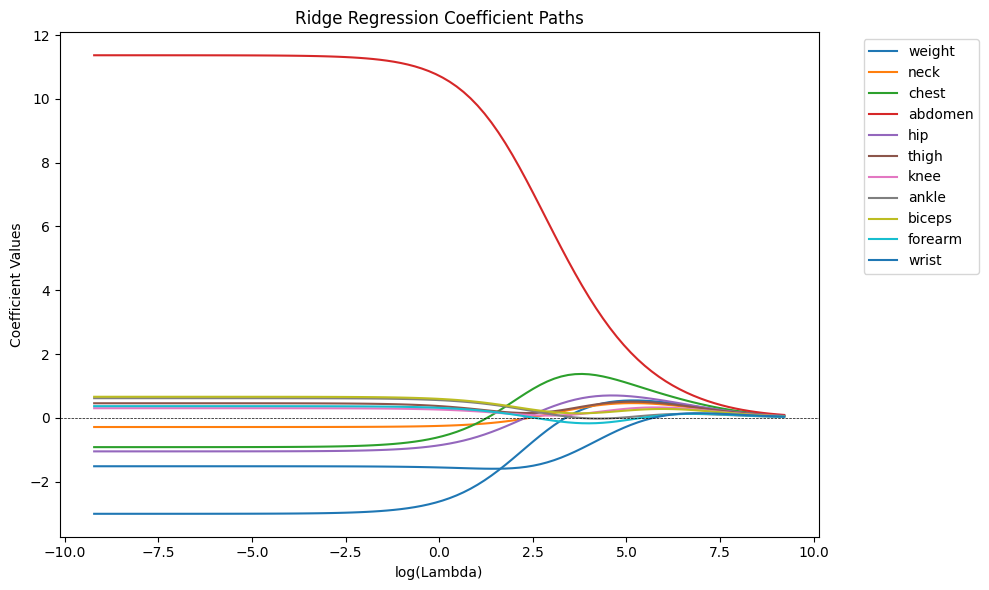

In [12]:
# PLOT COEFFICIENT PATHS FOR RIDGE REGRESSION VS LOG(LAMBDA)

plt.figure(figsize=(10, 6))
for i, name in enumerate(X_train.columns):
    plt.plot(np.log(lambdas), coefficients_ridge[:, i], label=name)

plt.xlabel('log(Lambda)')
plt.ylabel('Coefficient Values')
plt.title('Ridge Regression Coefficient Paths')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [13]:
# LASSO REGRESSION OVER LAMBDA GRID

coefficients_lasso = []

for lam in lambdas:
    lasso = Lasso(alpha=lam, fit_intercept=True)
    lasso.fit(X_train, y_train)
    coefficients_lasso.append(lasso.coef_)

coefficients_lasso = np.array(coefficients_lasso) # shape (n_lambdas, n_features)

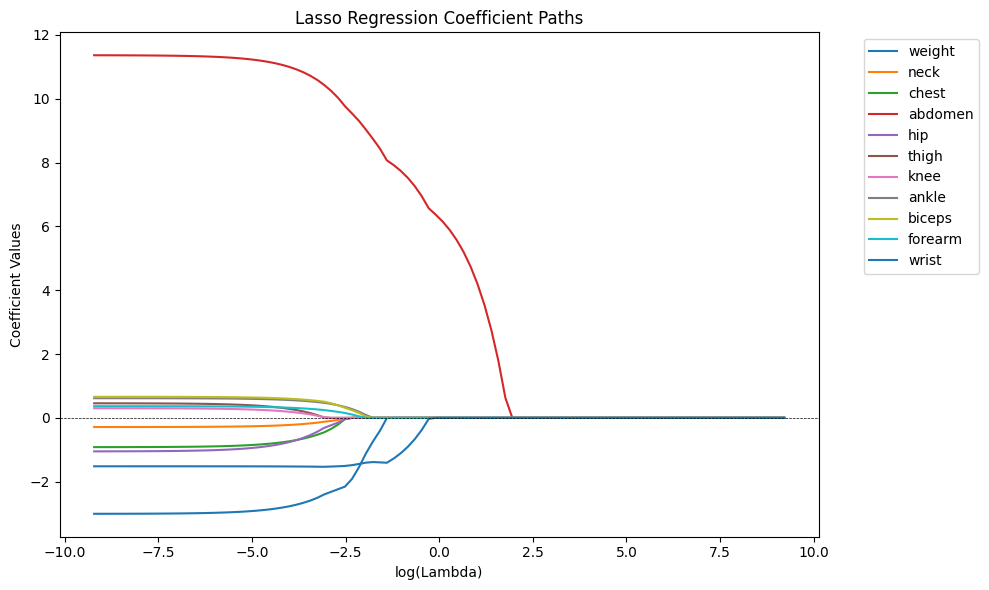

In [14]:
# PLOT COEFFICIENT PATHS FOR LASSO REGRESSION VS LOG(LAMBDA)

plt.figure(figsize=(10, 6))
for i, name in enumerate(X_train.columns):
    plt.plot(np.log(lambdas), coefficients_lasso[:, i], label=name)

plt.xlabel('log(Lambda)')
plt.ylabel('Coefficient Values')
plt.title('Lasso Regression Coefficient Paths')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()    

- **Interpretation of Ridge and Lasso Coefficient Paths**

We plot the regression coefficients as functions of the regularization parameter $\lambda$ (on a logarithmic scale). These paths illustrate how regularization affects both the magnitude and structure of the fitted models.

- *Ridge Regression*

In ridge regression, all coefficients shrink smoothly toward zero as $\lambda$ increases. No coefficient becomes exactly zero for finite $\lambda$, which reflects the fact that ridge regression does not perform variable selection. Instead, it stabilizes estimation in the presence of multicollinearity by distributing the effect across correlated predictors.

From the plot, we observe that the coefficient corresponding to **abdomen** is dominant for small values of $\lambda$, indicating that abdominal circumference is the strongest predictor of body fat percentage. As $\lambda$ increases, this coefficient decreases gradually but remains non-negligible longer than the others. Variables such as weight, hip, thigh, and chest exhibit moderate coefficients and shrink in a coordinated manner, which is consistent with the presence of correlation among anthropometric measurements.

Overall, the ridge path suggests that while several predictors contribute to the model, abdomen carries most of the explanatory power, and ridge regularization primarily serves to control variance rather than eliminate variables.

---

- *Lasso Regression*

In contrast, the lasso coefficient paths show a qualitatively different behavior. As $\lambda$ increases, many coefficients are driven exactly to zero at finite values of $\lambda$. This reflects the variable selection property of the lasso, which yields sparse models.

The plot shows that **abdomen** remains nonzero over the widest range of $\lambda$, again highlighting its strong predictive importance. Most other predictors shrink rapidly to zero, indicating that once abdominal circumference is included, their additional contribution is comparatively limited. Only a small subset of variables survives for intermediate values of $\lambda$, leading to a parsimonious model.

Thus, while ridge regression retains all predictors with reduced magnitudes, lasso regression actively selects a smaller set of relevant variables. This difference will be crucial when comparing predictive performance and interpretability in the subsequent validation and cross-validation steps.


#### **Finding optimal value of $\lambda$ for both regressions.**

In [16]:
# RIDGE REGRESSION VALIDATION MSE OVER LAMBDA GRID

ridge_mse_validation = []

for lam in lambdas:
    ridge = Ridge(alpha=lam, fit_intercept=True)
    ridge.fit(X_train, y_train)
    y_validation_prediction = ridge.predict(X_validation)
    ridge_mse_validation.append(mean_squared_error(y_validation, y_validation_prediction))

ridge_mse_validation = np.array(ridge_mse_validation)

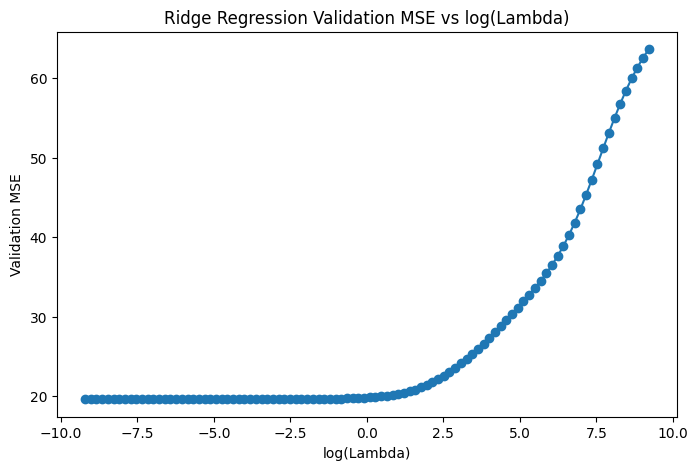

In [17]:
# PLOT RIDGE REGRESSION VALIDATION MSE VS LOG(LAMBDA)

plt.figure(figsize=(8, 5))

plt.plot(np.log(lambdas), ridge_mse_validation, marker='o')
plt.xlabel('log(Lambda)')
plt.ylabel('Validation MSE')
plt.title('Ridge Regression Validation MSE vs log(Lambda)')
plt.show()

In [18]:
ridge_best_index = np.argmin(ridge_mse_validation)
ridge_best_lambda = lambdas[ridge_best_index]
ridge_best_mse = ridge_mse_validation[ridge_best_index]

print(f"Best Ridge Lambda: {ridge_best_lambda}")
print(f"Best Ridge Validation MSE: {ridge_best_mse}")

Best Ridge Lambda: 0.0001
Best Ridge Validation MSE: 19.615858198256305


In [20]:
# LASSO REGRESSION VALIDATION MSE OVER LAMBDA GRID

lasso_mse_validation = []

for lam in lambdas:
    lasso = Lasso(alpha=lam, fit_intercept=True)
    lasso.fit(X_train, y_train)
    y_validation_prediction = lasso.predict(X_validation)
    lasso_mse_validation.append(mean_squared_error(y_validation, y_validation_prediction))

lasso_mse_validation = np.array(lasso_mse_validation)

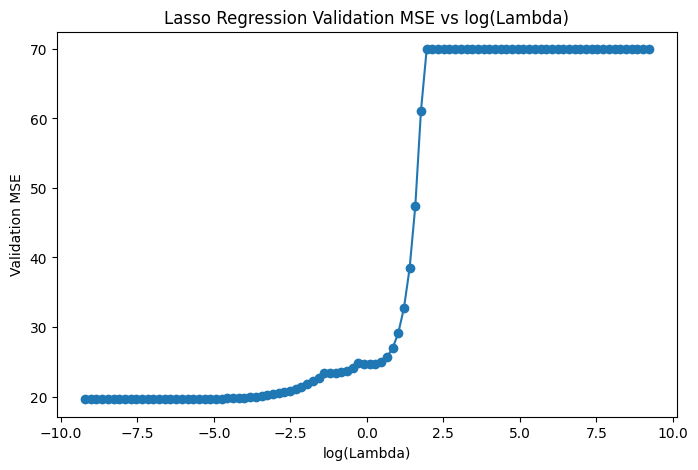

In [21]:
# PLOT LASSO REGRESSION VALIDATION MSE VS LOG(LAMBDA)

plt.figure(figsize=(8, 5))

plt.plot(np.log(lambdas), lasso_mse_validation, marker='o')
plt.xlabel('log(Lambda)')
plt.ylabel('Validation MSE')
plt.title('Lasso Regression Validation MSE vs log(Lambda)')
plt.show()

In [24]:
# FIND BEST LASSO LAMBDA AND MSE

lasso_best_index = np.argmin(lasso_mse_validation)
lasso_best_lambda = lambdas[lasso_best_index]
lasso_best_mse = lasso_mse_validation[lasso_best_index]

print(f"Best Lasso Lambda: {lasso_best_lambda}")
print(f"Best Lasso Validation MSE: {lasso_best_mse}")

Best Lasso Lambda: 0.0001
Best Lasso Validation MSE: 19.616856173066843


##### **Validation-set selection of $\lambda$**

Using a random split of the data into 152 training observations and 100 validation observations, we evaluated the validation mean squared error (MSE) for ridge and lasso regression over a logarithmic grid of $\lambda$ values.

For both methods, the validation error is minimized for a very small value of the regularization parameter:
- **Ridge:** $\hat{\lambda}_{\text{val}} = 10^{-4}$, with validation MSE $\approx 19.62$
- **Lasso:** $\hat{\lambda}_{\text{val}} = 10^{-4}$, with validation MSE $\approx 19.62$

From the validation error curves, we observe that for small $\lambda$, the error is relatively flat, indicating that little regularization is needed to achieve good predictive performance. As $\lambda$ increases, the validation error rises sharply for both methods, reflecting underfitting due to excessive shrinkage. This effect is particularly abrupt for the lasso, where the error increases dramatically once most coefficients are forced to zero.

The near-identical validation errors obtained by ridge and lasso at their optimal $\lambda$ values suggest that, for this particular train–validation split, both methods achieve comparable predictive performance. However, they do so with different coefficient structures, as seen in the coefficient path plots: ridge retains all predictors with small coefficients, whereas lasso favors a sparse model.


#### **Changing the seed for train\validation split**

this should change the validation set and thus we'll be able to observe if any results change

In [25]:
# TRAIN/VALIDATION SPLIT (WITH DIFFERENT RANDOM SEED)

np.random.seed(5)

n = data_scaled.shape[0]
train_idx = np.random.choice(n, size=152, replace=False)
validation_idx = np.setdiff1d(np.arange(n), train_idx)

X_train = data_scaled.iloc[train_idx].reset_index(drop=True)
y_train = siri.iloc[train_idx].reset_index(drop=True)

X_validation = data_scaled.iloc[validation_idx].reset_index(drop=True)
y_validation = siri.iloc[validation_idx].reset_index(drop=True)

print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_validation.shape, y_validation.shape)

Training set size: (152, 11) (152,)
Validation set size: (100, 11) (100,)


##### **Ridge Regression Redo**

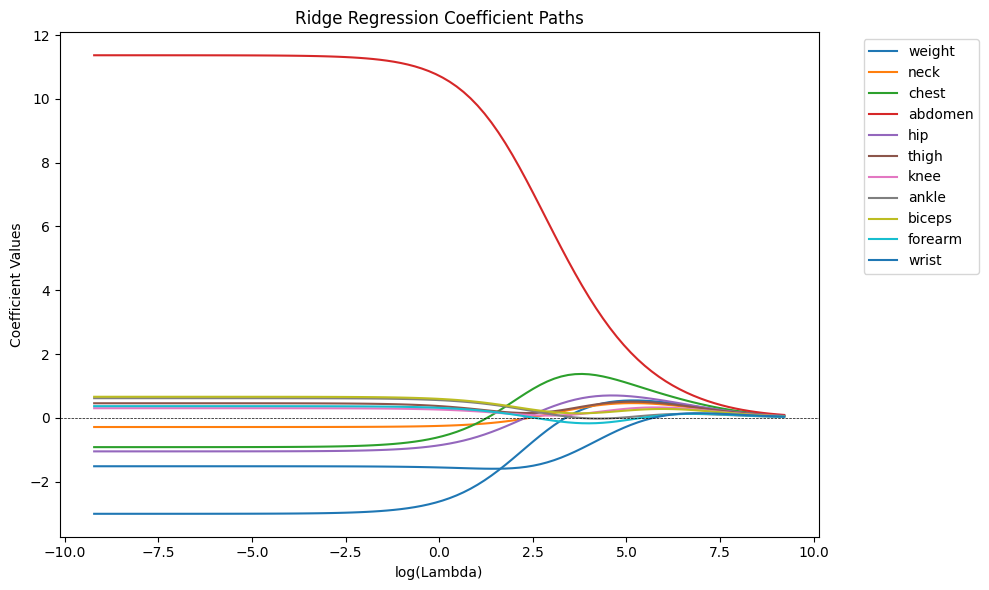

In [ ]:
# RIDGE REGRESSION REDO OVER LAMBDA GRID

coefficients_ridge2 = []

for lam in lambdas:
    ridge = Ridge(alpha=lam, fit_intercept=True)
    ridge.fit(X_train, y_train)
    coefficients_ridge2.append(ridge.coef_)

coefficients_ridge2 = np.array(coefficients_ridge2) # shape (n_lambdas, n_features)

plt.figure(figsize=(10, 6))
for i, name in enumerate(X_train.columns):
    plt.plot(np.log(lambdas), coefficients_ridge[:, i], label=name)

plt.xlabel('log(Lambda)')
plt.ylabel('Coefficient Values')
plt.title('Ridge Regression Coefficient Paths')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

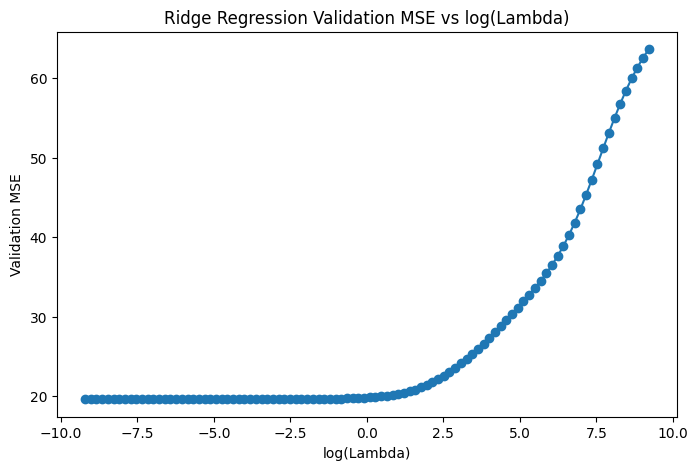

Best Ridge Lambda: 0.0001
Best Ridge Validation MSE: 25.158783560742037


In [27]:
# RIDGE REGRESSION LAMBDA SELECTION OVER NEW SPLIT

ridge_mse_validation2 = []

for lam in lambdas:
    ridge = Ridge(alpha=lam, fit_intercept=True)
    ridge.fit(X_train, y_train)
    y_validation_prediction = ridge.predict(X_validation)
    ridge_mse_validation2.append(mean_squared_error(y_validation, y_validation_prediction))

ridge_mse_validation2 = np.array(ridge_mse_validation2)

## Plot

plt.figure(figsize=(8, 5))

plt.plot(np.log(lambdas), ridge_mse_validation, marker='o')
plt.xlabel('log(Lambda)')
plt.ylabel('Validation MSE')
plt.title('Ridge Regression Validation MSE vs log(Lambda)')
plt.show()

## Result

ridge_best_index2 = np.argmin(ridge_mse_validation2)
ridge_best_lambda2 = lambdas[ridge_best_index2]
ridge_best_mse2 = ridge_mse_validation2[ridge_best_index2]

print(f"Best Ridge Lambda: {ridge_best_lambda2}")
print(f"Best Ridge Validation MSE: {ridge_best_mse2}")

##### **Lasso Regression Redo**

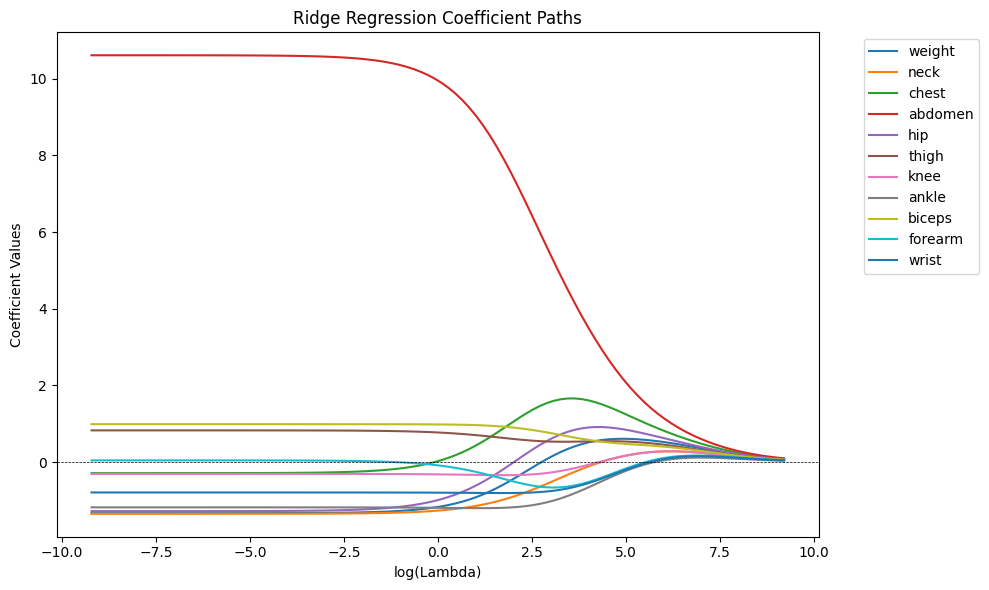

In [28]:
coefficients_lasso2 = []

for lam in lambdas:
    ridge = Ridge(alpha=lam, fit_intercept=True)
    ridge.fit(X_train, y_train)
    coefficients_lasso2.append(ridge.coef_)

coefficients_lasso2 = np.array(coefficients_lasso2) # shape (n_lambdas, n_features)

plt.figure(figsize=(10, 6))
for i, name in enumerate(X_train.columns):
    plt.plot(np.log(lambdas), coefficients_lasso2[:, i], label=name)
    
plt.xlabel('log(Lambda)')
plt.ylabel('Coefficient Values')
plt.title('Ridge Regression Coefficient Paths')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

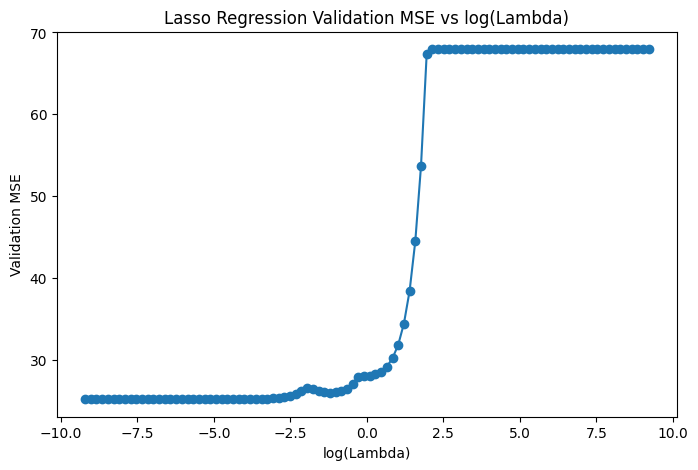

Best Lasso Lambda: 0.0001
Best Lasso Validation MSE: 25.15978003957825


In [29]:
# LASSO REGRESSION LAMBDA SELECTION OVER NEW SPLIT

lasso_mse_validation2 = []

for lam in lambdas:
    lasso = Lasso(alpha=lam, fit_intercept=True)
    lasso.fit(X_train, y_train)
    y_validation_prediction = lasso.predict(X_validation)
    lasso_mse_validation2.append(mean_squared_error(y_validation, y_validation_prediction))

lasso_mse_validation2 = np.array(lasso_mse_validation2)

## Plot

plt.figure(figsize=(8, 5))

plt.plot(np.log(lambdas), lasso_mse_validation2, marker='o')
plt.xlabel('log(Lambda)')
plt.ylabel('Validation MSE')
plt.title('Lasso Regression Validation MSE vs log(Lambda)')
plt.show()

## Result

lasso_best_index2 = np.argmin(lasso_mse_validation2)
lasso_best_lambda2 = lambdas[lasso_best_index2]
lasso_best_mse2 = lasso_mse_validation2[lasso_best_index2]

print(f"Best Lasso Lambda: {lasso_best_lambda2}")
print(f"Best Lasso Validation MSE: {lasso_best_mse2}")

##### **Effect of changing the random split**

With the new random split, the selected regularization parameters remain:
- **Ridge:** $\hat{\lambda}_{\text{val}} = 10^{-4}$
- **Lasso:** $\hat{\lambda}_{\text{val}} = 10^{-4}$

However, the corresponding validation errors increase substantially:
- **Ridge validation MSE:** $\approx 25.16$
- **Lasso validation MSE:** $\approx 25.16$

This shows that while the qualitative behavior of the validation curves and the location of the optimal $\lambda$ are similar across splits, the numerical value of the validation error depends strongly on how the data are partitioned. In particular, the increase in validation MSE reflects the sensitivity of the validation-set approach to the specific random split, especially when the sample size is moderate.

These results illustrate a key limitation of single validation-set selection: the estimated optimal performance and error level can vary noticeably with the random split. This motivates the use of cross-validation methods, which average over multiple splits and typically provide more stable estimates of the optimal regularization parameter.


#### **Leave One Out Cross-Validation**

LOOCV creates as many folds as there are data points. Each observation gets its turn as a single-point test set while all remaining observations form the training set.

##### **Ridge Regression**

In [30]:
# RIDGE LOOCV

ridge_loocv_mse = []

for lam in lambdas:
    mse = []

    for i in range(n):
        X_train_loo = data_scaled.drop(index=i).reset_index(drop=True)
        y_train_loo = siri.drop(index=i).reset_index(drop=True)

        X_val_loo = data_scaled.iloc[[i]].reset_index(drop=True)
        y_val_loo = siri.iloc[[i]].reset_index(drop=True)

        ridge = Ridge(alpha=lam, fit_intercept=True)
        ridge.fit(X_train_loo, y_train_loo)
        y_val_pred = ridge.predict(X_val_loo)
        
        mse.append(mean_squared_error(y_val_loo, y_val_pred))

    ridge_loocv_mse.append(np.mean(mse))

ridge_loocv_mse = np.array(ridge_loocv_mse)

ridge_loocv_best_index = np.argmin(ridge_loocv_mse)
ridge_loocv_best_lambda = lambdas[ridge_loocv_best_index]
ridge_loocv_best_mse = ridge_loocv_mse[ridge_loocv_best_index]

print(f"Best Ridge LOOCV Lambda: {ridge_loocv_best_lambda}")
print(f"Best Ridge LOOCV MSE: {ridge_loocv_best_mse}")

Best Ridge LOOCV Lambda: 0.3593813663804629
Best Ridge LOOCV MSE: 19.969669737298542


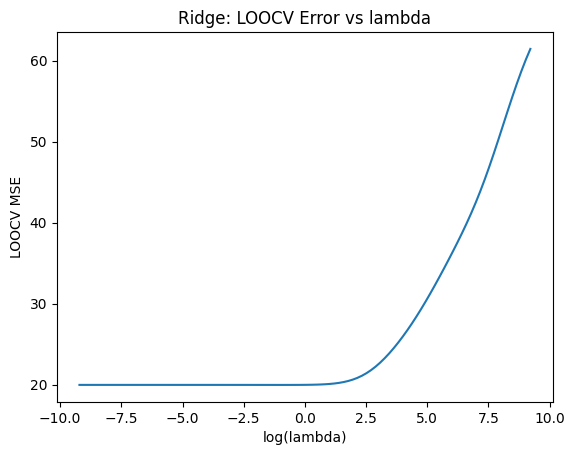

In [31]:
# PLOT RIDGE LOOCV MSE VS LOG(LAMBDA)

plt.figure()
plt.plot(np.log(lambdas), ridge_loocv_mse)
plt.xlabel("log(lambda)")
plt.ylabel("LOOCV MSE")
plt.title("Ridge: LOOCV Error vs lambda")
plt.show()


##### **Lasso Regression**

In [32]:
# LASSO LOOCV

lasso_loocv_mse = []

for lam in lambdas:
    mse = []

    for i in range(n):
        X_train_loo = data_scaled.drop(index=i).reset_index(drop=True)
        y_train_loo = siri.drop(index=i).reset_index(drop=True)

        X_val_loo = data_scaled.iloc[[i]].reset_index(drop=True)
        y_val_loo = siri.iloc[[i]].reset_index(drop=True)

        lasso = Lasso(alpha=lam, fit_intercept=True)
        lasso.fit(X_train_loo, y_train_loo)
        y_val_pred = lasso.predict(X_val_loo)
        
        mse.append(mean_squared_error(y_val_loo, y_val_pred))

    lasso_loocv_mse.append(np.mean(mse))

lasso_loocv_mse = np.array(lasso_loocv_mse)

lasso_loocv_best_index = np.argmin(lasso_loocv_mse)
lasso_loocv_best_lambda = lambdas[lasso_loocv_best_index]
lasso_loocv_best_mse = lasso_loocv_mse[lasso_loocv_best_index]

print(f"Best Lasso LOOCV Lambda: {lasso_loocv_best_lambda}")
print(f"Best Lasso LOOCV MSE: {lasso_loocv_best_mse}")

Best Lasso LOOCV Lambda: 0.018307382802953697
Best Lasso LOOCV MSE: 19.850828147570315


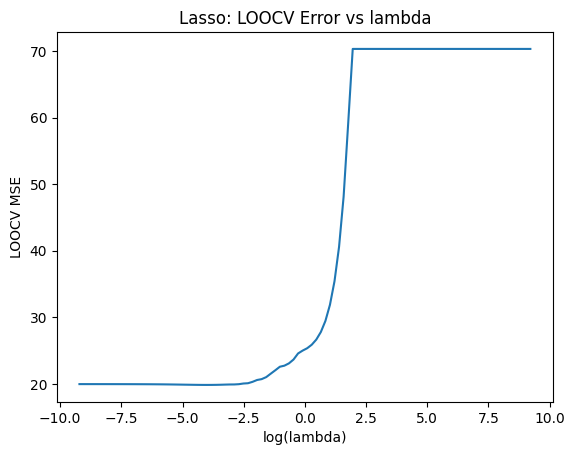

In [33]:
# PLOT LASSO LOOCV MSE VS LOG(LAMBDA)

plt.figure()
plt.plot(np.log(lambdas), lasso_loocv_mse)
plt.xlabel("log(lambda)")
plt.ylabel("LOOCV MSE")
plt.title("Lasso: LOOCV Error vs lambda")
plt.show()


##### **Summary**

We implemented leave-one-out cross-validation (LOOCV) to estimate the prediction error of ridge and lasso regression as a function of the regularization parameter $\lambda$. For each value of $\lambda$, the model was trained $n = 252$ times, each time leaving out one observation and evaluating the squared prediction error on the omitted point. The LOOCV error was then obtained by averaging these squared errors.

For **lasso regression**, the LOOCV error curve attains its minimum at
$$
\hat{\lambda}_{\text{CV}}^{\text{lasso}} \approx 1.83 \times 10^{-2},
$$
with a corresponding LOOCV MSE of approximately $19.85$.

For **ridge regression**, the minimum occurs at
$$
\hat{\lambda}_{\text{CV}}^{\text{ridge}} \approx 3.59 \times 10^{-1},
$$
with a corresponding LOOCV MSE of approximately $19.97$.

Compared to the single validation-set approach, the LOOCV-selected values of $\lambda$ are larger, reflecting a stronger degree of regularization. This is consistent with the fact that LOOCV effectively averages over all possible one-point splits and therefore penalizes overly complex models more strongly. Overall, LOOCV provides a more stable and principled choice of the regularization parameter than a single train–validation split.

#### **K-Fold Cross-Validation**

In [34]:
# GENERAL SETUP FOR K-FOLD CV

K = 10
np.random.seed(1)
indexes = np.random.permutation(n)
folds = np.array_split(indexes, K)

In [35]:
# RIDGE K-FOLD CV

ridge_kfold_mse = []

for lam in lambdas:
    mse_folds = []
    
    for k in range(K):
        val_idx = folds[k]
        train_idx = np.setdiff1d(np.arange(n), val_idx)
        
        X_train_k = data_scaled.iloc[train_idx].reset_index(drop=True)
        y_train_k = siri.iloc[train_idx].reset_index(drop=True)
        
        X_val_k = data_scaled.iloc[val_idx].reset_index(drop=True)
        y_val_k = siri.iloc[val_idx].reset_index(drop=True)
        
        ridge = Ridge(alpha=lam, fit_intercept=True)
        ridge.fit(X_train_k, y_train_k)
        y_val_pred = ridge.predict(X_val_k)
        
        mse_folds.append(mean_squared_error(y_val_k, y_val_pred))
    
    ridge_kfold_mse.append(np.mean(mse_folds))

ridge_kfold_mse = np.array(ridge_kfold_mse)

ridge_kfold_best_index = np.argmin(ridge_kfold_mse)
ridge_kfold_best_lambda = lambdas[ridge_kfold_best_index]
ridge_kfold_best_mse = ridge_kfold_mse[ridge_kfold_best_index]

print(f"Best Ridge K-Fold Lambda: {ridge_kfold_best_lambda}")
print(f"Best Ridge K-Fold MSE: {ridge_kfold_best_mse}")

Best Ridge K-Fold Lambda: 0.20565123083486536
Best Ridge K-Fold MSE: 20.110999414385837


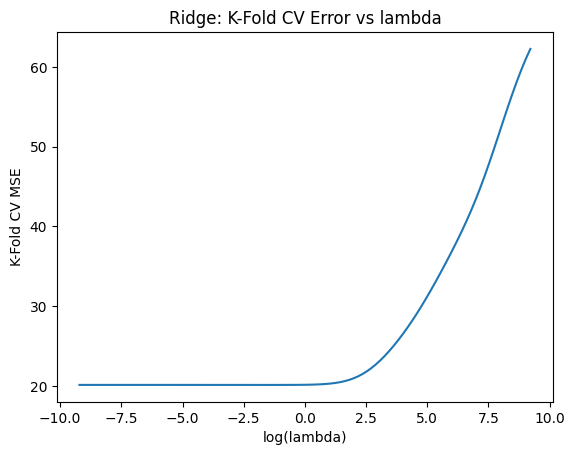

In [36]:
# PLOT RIDGE K-FOLD MSE VS LOG(LAMBDA)

plt.figure()
plt.plot(np.log(lambdas), ridge_kfold_mse)
plt.xlabel("log(lambda)")
plt.ylabel("K-Fold CV MSE")
plt.title("Ridge: K-Fold CV Error vs lambda")
plt.show()

In [37]:
# LASSO K-FOLD CV

lasso_kfold_mse = []

for lam in lambdas:
    mse_folds = []
    
    for k in range(K):
        val_idx = folds[k]
        train_idx = np.setdiff1d(np.arange(n), val_idx)
        
        X_train_k = data_scaled.iloc[train_idx].reset_index(drop=True)
        y_train_k = siri.iloc[train_idx].reset_index(drop=True)
        
        X_val_k = data_scaled.iloc[val_idx].reset_index(drop=True)
        y_val_k = siri.iloc[val_idx].reset_index(drop=True)
        
        lasso = Lasso(alpha=lam, fit_intercept=True)
        lasso.fit(X_train_k, y_train_k)
        y_val_pred = lasso.predict(X_val_k)
        
        mse_folds.append(mean_squared_error(y_val_k, y_val_pred))
    
    lasso_kfold_mse.append(np.mean(mse_folds))

lasso_kfold_mse = np.array(lasso_kfold_mse)

lasso_kfold_best_index = np.argmin(lasso_kfold_mse)
lasso_kfold_best_lambda = lambdas[lasso_kfold_best_index]
lasso_kfold_best_mse = lasso_kfold_mse[lasso_kfold_best_index]

print(f"Best Lasso K-Fold Lambda: {lasso_kfold_best_lambda}")
print(f"Best Lasso K-Fold MSE: {lasso_kfold_best_mse}")

Best Lasso K-Fold Lambda: 0.015199110829529346
Best Lasso K-Fold MSE: 20.089832356814973


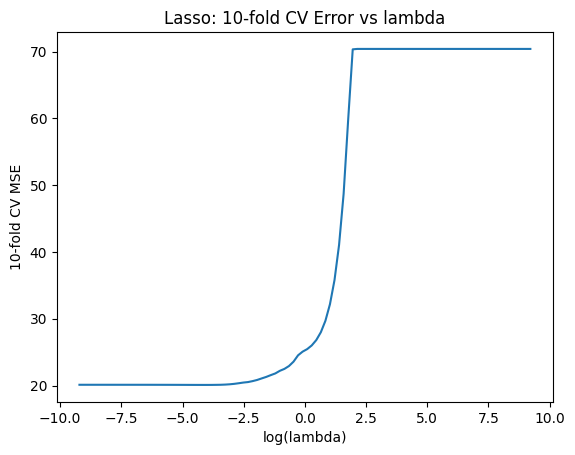

In [38]:
# PLOT LASSO K-FOLD MSE VS LOG(LAMBDA)

plt.figure()
plt.plot(np.log(lambdas), lasso_kfold_mse)
plt.xlabel("log(lambda)")
plt.ylabel(f"{K}-fold CV MSE")
plt.title(f"Lasso: {K}-fold CV Error vs lambda")
plt.show()

##### **Summary**

We implemented $K$-fold cross-validation (with $K=10$) to estimate the prediction error of ridge and lasso regression as a function of the regularization parameter $\lambda$. The data were randomly partitioned into $K$ folds; for each $\lambda$, the model was trained on $K-1$ folds and evaluated on the held-out fold, repeating this for all folds and averaging the resulting MSEs.

The $10$-fold CV error is minimized at:
- **Ridge:** $\hat{\lambda}_{\text{CV}}^{\text{ridge}} = \; 2.06 \times 10^{-1}\;$, with CV MSE $\approx 20.1$ 
- **Lasso:** $\hat{\lambda}_{\text{CV}}^{\text{lasso}} = \; 0.151 \times 10^{-1} \;$, with CV MSE $\approx 20.1$

Compared to LOOCV, $K$-fold CV typically provides a similar but less variable estimate of the optimal $\lambda$, while being significantly cheaper computationally. It also reduces the dependence on a single arbitrary train–validation split by averaging performance across multiple held-out subsets.
